In [34]:
import os
import os.path
import random
import csv
import sys
import numpy as np
import tensorflow as tf
%matplotlib inline
import PIL.Image
import numpy as np
from libs import utils, gif, datasets, dataset_utils, vae, dft
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
import IPython.display as ipyd

## Hyperparameters 

1. Thumbnail size - parameter "size"
2. Latent vector dimensionality - parameter "latent_dim"
3. Hidden dimensionality, i.e., number of neurons - parameter "h_dim"
4. Number of iterations
5. Image preprocessing (Binarizing, normalizing etc.)
6. Optimizer type - Adam, Adadelta, GradientDescentOptimizer, AdagradOptimizer etc..
7. Batch size

In [35]:
def csv_to_dict(csv_path):
    with open(csv_path,'r') as fp:
        csv_fp=csv.reader(fp)
        next(csv_fp)
        d = dict(filter(None, csv_fp))
        return d

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def FC_layer(X, W, b):
    return tf.matmul(X, W) + b

In [36]:
data_path="/home/intergalactic/cosmology_aux_data_170429"

# Paths
labeled_path=os.path.join(data_path,"labeled")
label_file=os.path.join(data_path,"labeled.csv")

# Initialization
label_dict=csv_to_dict(label_file)
img_prefixes=list(label_dict.keys())
img_prefixes_galaxy = dict((k, v) for k, v in label_dict.items() if float(v)==1.0)
img_prefixes_galaxy_keys = list(img_prefixes_galaxy.keys())
len(img_prefixes_galaxy)

# Input to the graph -- Galaxy images are 1000x1000
size = 128,128
n_pixels = size[0]*size[1]
X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

In [37]:
# Paths
s_labeled_path=os.path.join(data_path,"scored")
s_label_file=os.path.join(data_path,"scored.csv")

# Initialization
s_label_dict=csv_to_dict(s_label_file)
s_img_prefixes=list(s_label_dict.keys())
s_img_prefixes_galaxy = dict((k, v) for k, v in s_label_dict.items() if float(v)>3.0)
s_img_prefixes_galaxy_keys = list(s_img_prefixes_galaxy.keys())
len(s_img_prefixes_galaxy)

1165

In [38]:
data = np.ndarray(shape=(len(img_prefixes_galaxy) + len(s_img_prefixes_galaxy),size[0]*size[1]), order='F')
tmp = 0
for idx,img_prefix in enumerate(img_prefixes_galaxy):
#for idx in range(10):
    img_prefix=img_prefixes_galaxy_keys[idx]
    print("Loading image {} : {}/{}".format(img_prefix,idx+1,len(img_prefixes_galaxy)))
    print(os.path.join(labeled_path,"{}.png".format(img_prefix)))
    raw_image=PIL.Image.open(os.path.join(labeled_path,"{}.png".format(img_prefix)))#.convert('L').point(lambda x: 0 if x<128 else 255, '1')
    print("Raw size 0 = {} Raw size 1 = {}".format(raw_image.size[0],raw_image.size[1]))
    raw_image.thumbnail(size, PIL.Image.LANCZOS)
    #raw_image.save("/home/intergalactic/Prashanth/label_true_thumbnails/{}.png".format(img_prefix))
    img_arr=np.ravel(np.asarray(raw_image,dtype=np.uint8))
    data[idx] = img_arr
    tmp = idx

tmp += 1
for s_idx in range(1165):
    s_img_prefix=s_img_prefixes_galaxy_keys[idx]
    print("Loading scored image {} : {}/{}".format(s_img_prefix,s_idx+1,len(s_img_prefixes_galaxy)))
    print(os.path.join(s_labeled_path,"{}.png".format(s_img_prefix)))
    s_raw_image=PIL.Image.open(os.path.join(s_labeled_path,"{}.png".format(s_img_prefix)))
    print("Raw size 0 = {} Raw size 1 = {}".format(s_raw_image.size[0],s_raw_image.size[1]))
    s_raw_image.thumbnail(size, PIL.Image.LANCZOS)
    #raw_image.save("/home/intergalactic/Prashanth/label_true_thumbnails/{}.png".format(img_prefix))
    s_img_arr=np.ravel(np.asarray(s_raw_image,dtype=np.uint8))
    data[tmp] = s_img_arr
    tmp += 1
    # DEBUGGING
    
    #print(type(img_arr))
    #np.concatenate((img_arr, np.ravel(np.asarray(raw_image,dtype=np.uint8))), axis=0)
    #print(img_arr)
    #imgarr = np.ravel(np.asarray(raw_image,dtype=np.uint8))
    #print(np.ravel(imgarr))
    #imgplot = plt.imshow(raw_image)
    #print("Thumbnail size 0 = {} Thumbnail size 1 = {}".format(raw_image.size[0],raw_image.size[1]))
    #print(len(np.array(raw_image.getdata()).reshape(1,784)))
    #np.concatenate(img_arr, np.array(raw_image.getdata()).reshape(1,784))
    #img_arr=np.array(raw_image.getdata()).astype(np.uint8)
    #raw_image.getdata()

Loading image 9311528 : 1/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9311528.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9873679 : 2/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9873679.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7490527 : 3/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7490527.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9334887 : 4/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9334887.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9551063 : 5/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9551063.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2523268 : 6/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2523268.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8560076 : 7/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/8560076.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8026921 : 8/1000
/home/intergalactic/cosmology_aux_data

Loading image 2620671 : 65/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2620671.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9760653 : 66/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9760653.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5869122 : 67/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5869122.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6759927 : 68/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6759927.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4221557 : 69/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4221557.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4650185 : 70/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4650185.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1743154 : 71/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1743154.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6967594 : 72/1000
/home/intergalactic/cosmology_

Loading image 9844906 : 135/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9844906.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2825279 : 136/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2825279.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1817625 : 137/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1817625.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6548779 : 138/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6548779.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8558458 : 139/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/8558458.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5606416 : 140/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5606416.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7289393 : 141/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7289393.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3412284 : 142/1000
/home/intergalactic/co

Loading image 1984762 : 206/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1984762.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3753757 : 207/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3753757.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9480959 : 208/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9480959.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6307544 : 209/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6307544.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7076024 : 210/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7076024.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4180899 : 211/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4180899.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4500205 : 212/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4500205.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3470379 : 213/1000
/home/intergalactic/co

Loading image 3891078 : 277/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3891078.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9735230 : 278/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9735230.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3940038 : 279/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3940038.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1229842 : 280/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1229842.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3672811 : 281/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3672811.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3037514 : 282/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3037514.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6693430 : 283/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6693430.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7618767 : 284/1000
/home/intergalactic/co

Loading image 8060616 : 348/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/8060616.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6449661 : 349/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6449661.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5875815 : 350/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5875815.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9595938 : 351/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9595938.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3341154 : 352/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3341154.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9408852 : 353/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9408852.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5845013 : 354/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5845013.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5022989 : 355/1000
/home/intergalactic/co

Loading image 2505407 : 420/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2505407.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1780438 : 421/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1780438.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5352082 : 422/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5352082.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5283916 : 423/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5283916.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5058403 : 424/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5058403.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3001656 : 425/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3001656.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3491401 : 426/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3491401.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2049356 : 427/1000
/home/intergalactic/co

Loading image 9875530 : 483/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9875530.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2811634 : 484/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2811634.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1683652 : 485/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1683652.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1233495 : 486/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1233495.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1020724 : 487/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1020724.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4103748 : 488/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4103748.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2104267 : 489/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2104267.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5570924 : 490/1000
/home/intergalactic/co

Loading image 7788595 : 554/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7788595.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4659805 : 555/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4659805.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1661222 : 556/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1661222.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6326496 : 557/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6326496.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6978016 : 558/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6978016.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6175322 : 559/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6175322.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7443574 : 560/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7443574.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1767475 : 561/1000
/home/intergalactic/co

Loading image 5395822 : 624/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5395822.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7953391 : 625/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7953391.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1629257 : 626/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1629257.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7417151 : 627/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7417151.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8606941 : 628/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/8606941.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6507900 : 629/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6507900.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6279713 : 630/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6279713.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4462096 : 631/1000
/home/intergalactic/co

Loading image 1192873 : 694/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1192873.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9864908 : 695/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9864908.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7995226 : 696/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7995226.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5276242 : 697/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5276242.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7674822 : 698/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7674822.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6022466 : 699/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6022466.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5145769 : 700/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5145769.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9266911 : 701/1000
/home/intergalactic/co

Loading image 7956510 : 764/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7956510.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8961336 : 765/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/8961336.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4826647 : 766/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4826647.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8794973 : 767/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/8794973.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2838031 : 768/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2838031.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4374764 : 769/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4374764.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8652703 : 770/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/8652703.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8147426 : 771/1000
/home/intergalactic/co

Loading image 1709578 : 834/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1709578.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3466265 : 835/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3466265.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3212874 : 836/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3212874.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3837456 : 837/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3837456.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6671716 : 838/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6671716.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2263508 : 839/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2263508.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5345805 : 840/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5345805.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3364145 : 841/1000
/home/intergalactic/co

/home/intergalactic/cosmology_aux_data_170429/labeled/2044412.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 4688111 : 906/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/4688111.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3858111 : 907/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3858111.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 7929481 : 908/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/7929481.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9344639 : 909/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9344639.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2557108 : 910/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2557108.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 8876466 : 911/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/8876466.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9836257 : 912/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9

Loading image 5679758 : 976/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/5679758.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3086499 : 977/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3086499.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 1425483 : 978/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/1425483.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 9444820 : 979/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/9444820.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 6375499 : 980/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/6375499.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 2047256 : 981/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/2047256.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 3179932 : 982/1000
/home/intergalactic/cosmology_aux_data_170429/labeled/3179932.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading image 5860616 : 983/1000
/home/intergalactic/co

Loading scored image 2659747 : 45/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 46/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 47/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 48/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 49/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 50/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 51/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image

Loading scored image 2659747 : 120/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 121/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 122/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 123/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 124/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 125/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 126/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 195/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 196/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 197/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 198/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 199/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 200/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 201/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 270/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 271/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 272/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 273/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 274/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 275/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 276/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 344/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 345/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 346/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 347/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 348/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 349/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 350/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 419/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 420/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 421/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 422/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 423/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 424/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 425/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 493/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 494/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 495/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 496/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 497/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 498/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 499/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 566/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 567/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 568/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 569/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 570/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 571/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 572/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 641/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 642/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 643/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 644/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 645/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 646/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 647/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 711/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 712/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 713/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 714/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 715/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 716/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 717/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 786/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 787/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 788/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 789/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 790/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 791/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 792/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 861/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 862/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 863/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 864/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 865/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 866/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 867/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 936/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 937/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 938/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 939/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 940/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 941/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 942/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading score

Loading scored image 2659747 : 1011/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1012/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1013/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1014/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1015/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1016/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1017/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loadin

Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1086/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1087/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1088/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1089/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1090/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1091/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1092/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw si

Loading scored image 2659747 : 1160/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1161/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1162/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1163/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1164/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000
Loading scored image 2659747 : 1165/1165
/home/intergalactic/cosmology_aux_data_170429/scored/2659747.png
Raw size 0 = 1000 Raw size 1 = 1000


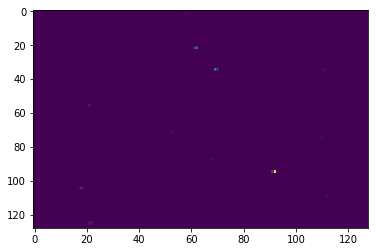

In [39]:
# DEBUGGING
# Check that the data is not corrupted 

# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
# test=mnist.train.next_batch(200)[0]
# type(test)

plt.imshow(data[2164].reshape(size),aspect="auto")
plt.show()
data.shape
ds = datasets.Dataset(data)

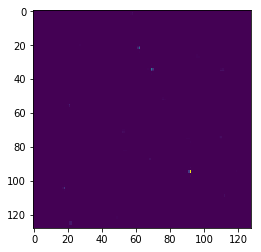

In [40]:
plt.imshow(ds.X[1].reshape(size))

In [41]:
# Encoder

latent_dim = 65
h_dim = 1000 

W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
b_enc = bias_variable([h_dim], 'b_enc')

# tanh activation function to replicate original model

h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

W_mu = weight_variable([h_dim, latent_dim], 'W_mu')
b_mu = bias_variable([latent_dim], 'b_mu')
mu = FC_layer(h_enc, W_mu, b_mu)

W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
b_logstd = bias_variable([latent_dim], 'b_logstd')
logstd = FC_layer(h_enc, W_logstd, b_logstd)

# Reparameterization trick

noise = tf.random_normal([1, latent_dim])
z = mu + tf.multiply(noise, tf.exp(.5*logstd))

In [42]:
# Decoder

W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
b_dec = bias_variable([h_dim], 'b_dec')
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))

W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

In [43]:
# Loss function

log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)
KL_term = -.5 * tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)
variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

In [44]:
# Training

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
saver = tf.train.Saver()

In [ ]:
import time

batch_size = 50
num_iterations = 10000
recording_interval = 1000
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []
iteration_array = [i*recording_interval for i in range(160)]
for i in range(num_iterations):
    for x_batch, _ in ds.train.next_batch(batch_size = batch_size):
        sess.run(optimizer, feed_dict={X: x_batch})
        if (i%recording_interval == 0):
            vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
            print("Iteration: {}, Loss: {}".format(i,vlb_eval))
            variational_lower_bound_array.append(vlb_eval)
            log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
            KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))
#        tmp_z = sess.run(z)
#        print(z)
#saver.save(sess, 'VAE' + batch_size + num_iterations, global_step=recording_interval, write_meta_graph=False)

Iteration: 0, Loss: -548698.0625
Iteration: 0, Loss: -244090.5
Iteration: 0, Loss: -198325.28125
Iteration: 0, Loss: -5505874.0
Iteration: 0, Loss: -191275.015625
Iteration: 0, Loss: -63361.8203125
Iteration: 0, Loss: -99929.4296875
Iteration: 0, Loss: -27663596.0
Iteration: 0, Loss: -41499.46875
Iteration: 0, Loss: -647735.75
Iteration: 0, Loss: -116991.1875
Iteration: 0, Loss: -104248.3515625
Iteration: 0, Loss: -172519.5
Iteration: 0, Loss: -1271061.125
Iteration: 0, Loss: -200569.3125
Iteration: 0, Loss: -342083.125
Iteration: 0, Loss: -9559741.0
Iteration: 0, Loss: -304700160.0
Iteration: 0, Loss: -371710.125
Iteration: 0, Loss: -434939.09375
Iteration: 0, Loss: -68037.3359375
Iteration: 0, Loss: -560398.625
Iteration: 0, Loss: -78284.0078125
Iteration: 0, Loss: -21553544.0
Iteration: 0, Loss: -493103.96875
Iteration: 0, Loss: -530750.875
Iteration: 0, Loss: -200194.046875
Iteration: 0, Loss: -835164.5
Iteration: 0, Loss: -491651.46875
Iteration: 0, Loss: -1052037.875
Iteration: 0

In [ ]:
plt.figure()
plt.plot(iteration_array, variational_lower_bound_array[1500:])
plt.plot(iteration_array, KL_term_array[1500:])
plt.plot(iteration_array, log_likelihood_array[1500:])
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')

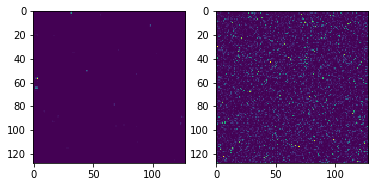

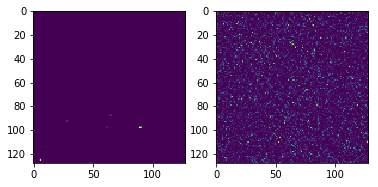

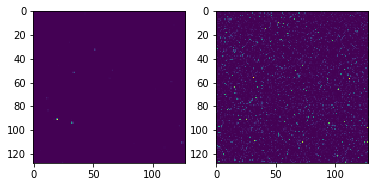

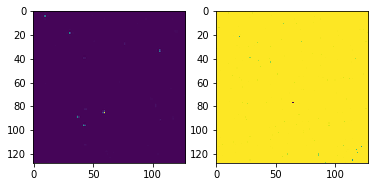

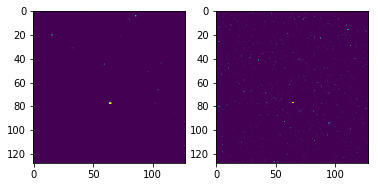

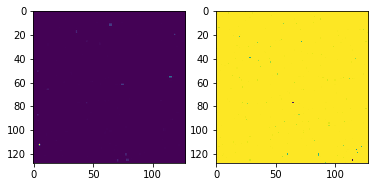

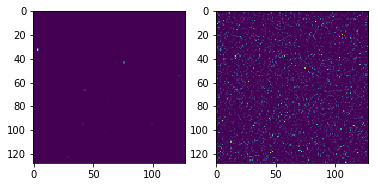

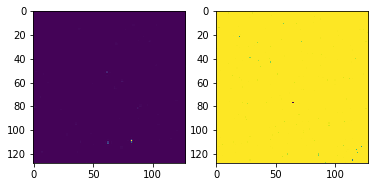

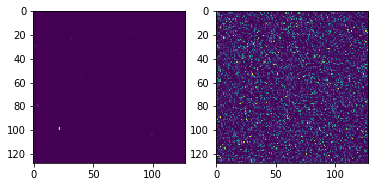

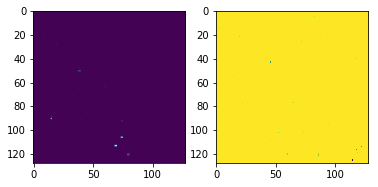

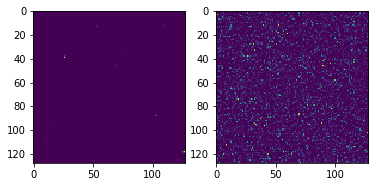

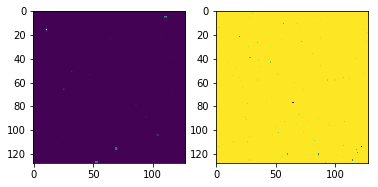

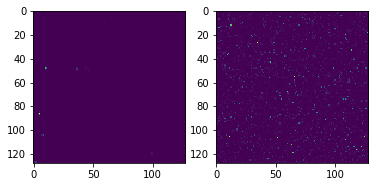

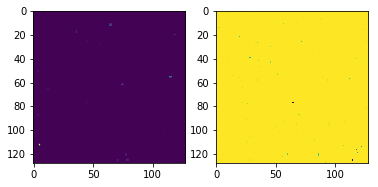

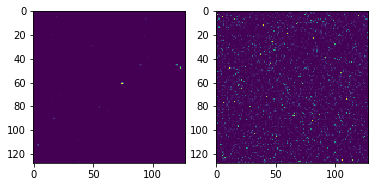

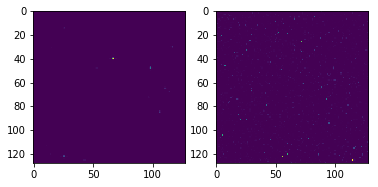

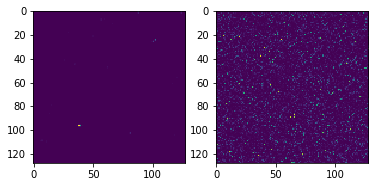

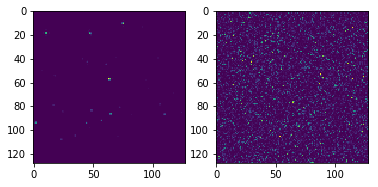

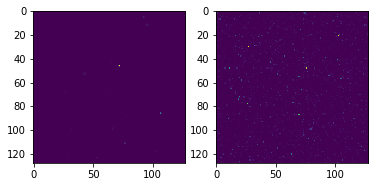

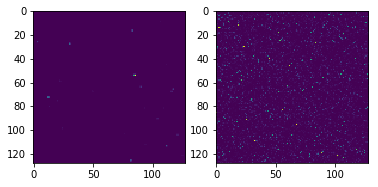

In [70]:
num_pairs = 20
image_indices = np.random.randint(0, 200, num_pairs)
for pair in range(num_pairs):
    x = np.reshape(data[image_indices[pair]], (1,n_pixels))
    plt.figure()
    x_image = np.reshape(x, (size))
    plt.subplot(121)
    plt.imshow(x_image)
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    x_reconstruction_image = (np.reshape(x_reconstruction, (size)))
    plt.imsave("/home/intergalactic/Prashanth/batch_output/{}.png".format(pair),x_reconstruction_image)
    plt.subplot(122) 
    plt.imshow(x_reconstruction_image)

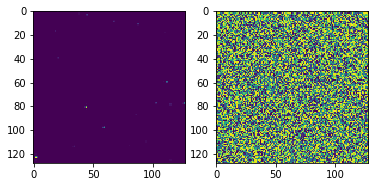

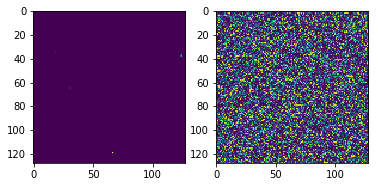

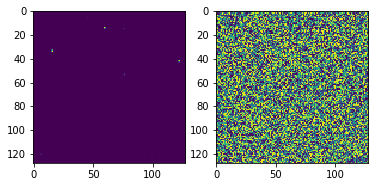

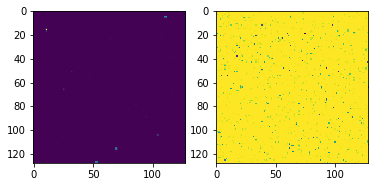

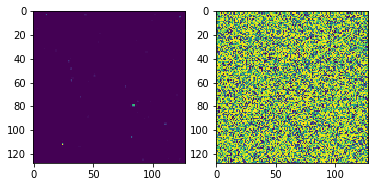

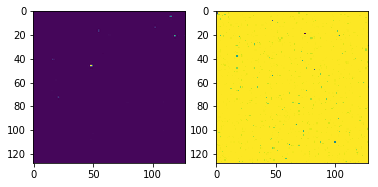

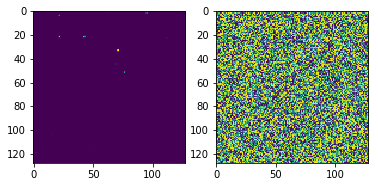

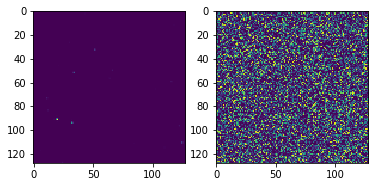

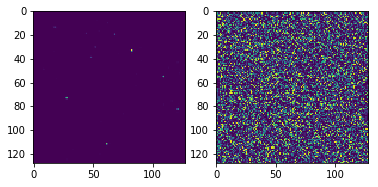

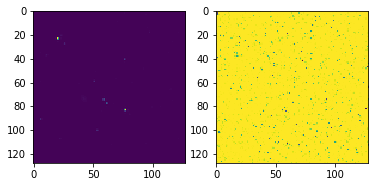

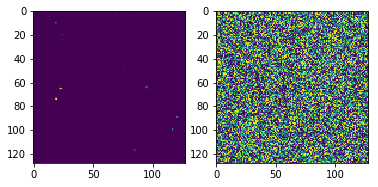

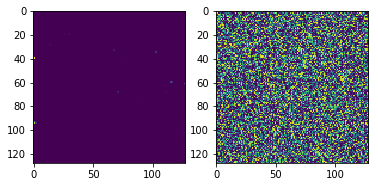

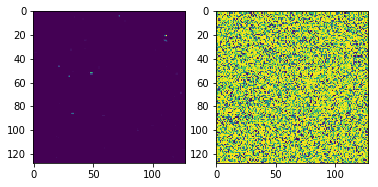

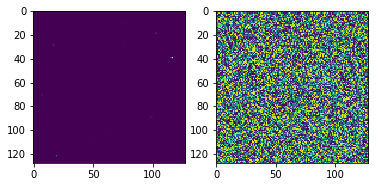

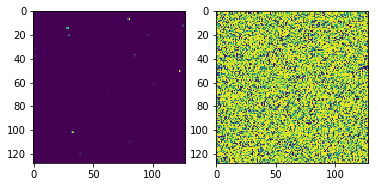

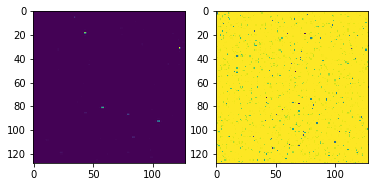

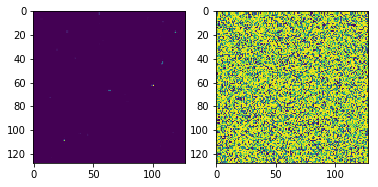

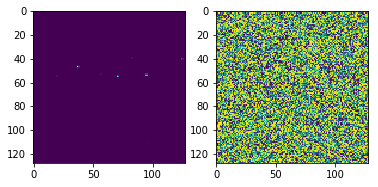

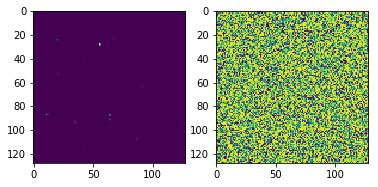

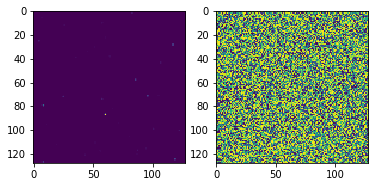

In [56]:
#Batch size 100, 10000 iterations, latent dimensionality 100, h_dim 1000, 128*128 images
num_pairs = 20
image_indices = np.random.randint(0, 200, num_pairs)
for pair in range(num_pairs):
    x = np.reshape(data[image_indices[pair]], (1,n_pixels))
    plt.figure()
    x_image = np.reshape(x, (size))
    plt.subplot(121)
    plt.imshow(x_image)
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    x_reconstruction_image = (np.reshape(x_reconstruction, (size)))
    plt.imsave("/home/intergalactic/Prashanth/batch_output/{}.png".format(pair),x_reconstruction_image)
    plt.subplot(122) 
    plt.imshow(x_reconstruction_image)